# Imports

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Functions

In [2]:
def json_to_df(file_path):
    # Load the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extracting relevant data from each record
    extracted_data = []
    for record in data:
        client_name = record['sender']['name']
        correlation_id = record['correlationId']
        training_info = json.loads(record['data'])
        extracted_data.append({
            'client': client_name,
            'correlationId': correlation_id,
            'training_loss': training_info['training_loss'],
            'training_accuracy': training_info['training_accuracy'],
            'test_loss': training_info['test_loss'],
            'test_accuracy': training_info['test_accuracy']
        })

    # Creating a DataFrame from the extracted data
    df = pd.DataFrame(extracted_data)

    # Creating a mapping of correlationId to readable round numbers
    unique_correlation_ids = df['correlationId'].unique()
    round_mapping = {correlation_id: f'Round {i+1}' for i, correlation_id in enumerate(unique_correlation_ids)}

    # Applying the mapping to the DataFrame
    df['Round'] = df['correlationId'].map(round_mapping)

    # Initializing the aggregated data dictionary with lists for each metric
    aggregated_data = {
        'Round': [],
        'training_accuracy': [],
        'training_loss': [],
        'test_accuracy': [],
        'test_loss': []
    }

    # Aggregating data for each round
    for round_label in df['Round'].unique():
        round_data = df[df['Round'] == round_label]
        aggregated_data['Round'].extend([round_label] * len(round_data))
        aggregated_data['training_accuracy'].extend(round_data['training_accuracy'])
        aggregated_data['training_loss'].extend(round_data['training_loss'])
        aggregated_data['test_accuracy'].extend(round_data['test_accuracy'])
        aggregated_data['test_loss'].extend(round_data['test_loss'])

    # Converting aggregated data into a DataFrame for plotting
    df_aggregated = pd.DataFrame(aggregated_data)


    # Create copy of df
    df = df_aggregated.copy()


    # Group by Round and calculate mean
    df = df.groupby('Round').mean()


    # Sort by index
    df.index = df.index.astype(str)
    numeric_index = df.index.str.extract('(\d+)')[0].astype(int)
    df = df.iloc[numeric_index.argsort()]
    
    return df

# Solution

In [23]:
#root = "Label_Flipping_Random/5_clients_10_rounds"
#files = ['5_client_baseline.json', '5_client_20.json', '5_client_40.json', '5_client_60.json', '5_client_80.json']
#file_labels = ['Baseline', '20% Poisoned', '40% Poisoned', '60% Poisoned', '80% Poisoned'] 


#root = "Label_Flipping_Random/10_clients_20_rounds"
#files = ['10_client_baseline.json', '10_client_10.json', '10_client_20.json', '10_client_30.json', '10_client_40.json']
#file_labels = ['Baseline', '10% Poisoned', '20% Poisoned', '30% Poisoned', '40% Poisoned'] 


#root = "Label_Flipping_Random/10_clients_40_rounds"
#files = ['10_client_baseline.json','10_client_10.json','10_client_20.json','10_client_30.json','10_client_40.json']
#file_labels = ['Baseline','10% Poisoned','20% Poisoned','30% Poisoned', '40% Poisoned'] 


#root = "Label_Flipping_Random/constant_20%"
#files = ['5_client_20.json','10_client_20.json']
#file_labels = ['5 Clients','10 Clients'] 


###############################################################################################


root = "Backdoor_Attack/5_clients_40_rounds"
files = ['5_client_baseline.json','5_client_20.json']
file_labels = ['Baseline','20% Backdoor'] 



###############################################################################################

#root = "Baselines"
#files = ['5_clients_10_rounds.json','5_clients_20_rounds.json','5_clients_40_rounds.json']
#file_labels = ['5 clients 10 rounds','5 clients 20 rounds','5 clients 40 rounds'] 


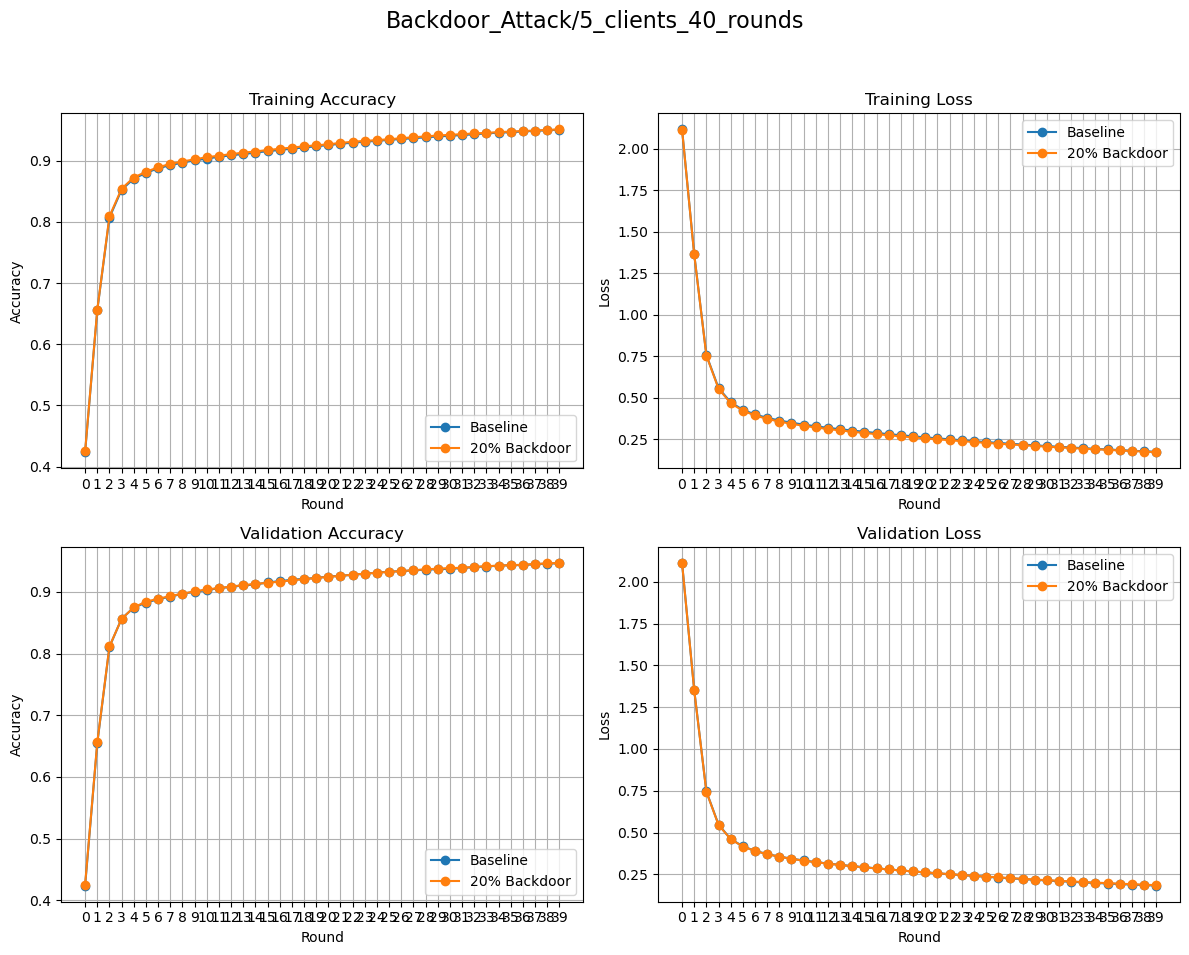

In [24]:
file_paths = [root+"/"+file for file in files]


# Load data from files
dfs = []
for path in file_paths:
    dfs.append(json_to_df(path))

# Create 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over each dataframe and plot on the same axes
for df, label in zip(dfs, file_labels):
    axs[0, 0].plot(df.index, df['training_accuracy'], marker='o', label=label)
    axs[0, 1].plot(df.index, df['training_loss'], marker='o', label=label)
    axs[1, 0].plot(df.index, df['test_accuracy'], marker='o', label=label)
    axs[1, 1].plot(df.index, df['test_loss'], marker='o', label=label)
    
    ticks = axs[0, 0].get_xticks()
    axs[0, 0].set_xticks(ticks)
    axs[0, 0].set_xticklabels(ticks)
    
    ticks = axs[0, 1].get_xticks()
    axs[0, 1].set_xticks(ticks)
    axs[0, 1].set_xticklabels(ticks)
    
    ticks = axs[1, 0].get_xticks()
    axs[1, 0].set_xticks(ticks)
    axs[1, 0].set_xticklabels(ticks)
    
    ticks = axs[1, 1].get_xticks()
    axs[1, 1].set_xticks(ticks)
    axs[1, 1].set_xticklabels(ticks)

    axs[0, 0].set_xlabel('Round')
    axs[0, 1].set_xlabel('Round')
    axs[1, 0].set_xlabel('Round')
    axs[1, 1].set_xlabel('Round')
    
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 1].set_ylabel('Loss')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 1].set_ylabel('Loss')
    
    
axs[0, 0].grid()
axs[0, 1].grid()
axs[1, 0].grid()
axs[1, 1].grid()

axs[0, 0].set_title('Training Accuracy')
axs[0, 1].set_title('Training Loss')
axs[1, 0].set_title('Validation Accuracy')
axs[1, 1].set_title('Validation Loss')

# Add legends
for ax in axs.flat:
    ax.legend()

# Title
plt.suptitle(root, fontsize=16)


# Adjust layout to accommodate the main title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# Savefig
plt.savefig(root+"/comparison.png")
